<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr9/Practice9_ebm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 281 (delta 68), reused 56 (delta 51), pack-reused 163
Receiving objects: 100% (281/281), 53.75 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=23393 sha256=91736e863945aeb710c6468cd3ed5c9e8551ca348f71e9a596c7213fb6e10bf5
  Stored in directory: /tmp/pip-ephem-wheel-cache-y_u065sx/wheels/55/59/29/0fb1c6356521577

In [ ]:
import math
import numpy as np 
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_rgb
import matplotlib
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import copy

from scipy.stats import norm
from scipy.optimize import bisect

In [ ]:
%matplotlib inline 

In [ ]:
from dul_2021.utils.pr3_utils import *

In [ ]:
traindata = q1_sample_data_1()

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


# utils

In [ ]:
def plot_density(f):
    x_lim = (-4, 4)
    y_lim = (-4, 4)

    dx, dy = 0.025, 0.025

    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))

    densities = (f(mesh_xs).cpu().detach().numpy())

    plt.pcolor(x, y, np.exp(densities).reshape([y.shape[0], y.shape[1]]))
    plt.show()

In [ ]:
def plot(loss):
    plt.figure()
    x = np.arange(0, len(loss))

    plt.plot(x, loss, label='train loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Energy')

# Noise contrastrive estimation

Dataset 1


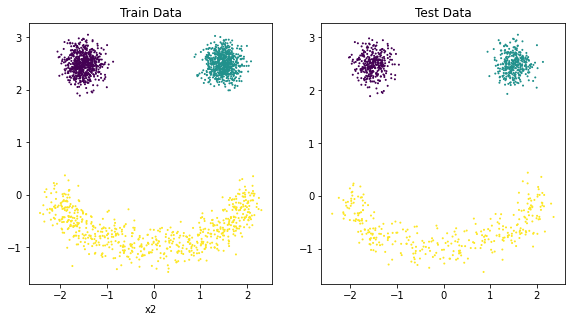

In [ ]:
visualize_q1_data(dset_type=1)

In [ ]:
class Net(nn.Module):
    def __init__(self, hd=128, out_dim=1):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, hd), 
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(hd, hd), 
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(hd, hd),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(hd, out_dim))

    def forward(self, x):
        x = self.model(x)
        return x 

In [ ]:
class NCEEnergyModel(nn.Module):
    def __init__(self, alpha=0.1, sig=1.6):
        super().__init__()
        
        self.model = Net()
        self.log_z = nn.Parameter(torch.Tensor([0.]), requires_grad=True)

        self.dist = torch.distributions.Normal(torch.Tensor([0]).to(device), torch.Tensor([sig]).to(device))
        self.alpha = alpha
 
    def forward(self, x):
        z = self.model(x)
        return z

    def loss(self, batch, noise=0):
        
        x_real = batch + torch.randn_like(batch) * noise
        x_real = x_real.float().to(device)
        
        x_fake = self.dist.sample(x_real.shape).squeeze()

        log_prob_fake = self.dist.log_prob(x_fake).reshape(x_real.shape[0], -1).sum(dim=-1, keepdim=True)
        log_prob_real = self.dist.log_prob(x_real).reshape(x_real.shape[0], -1).sum(dim=-1, keepdim=True)
        
        real_f = self.model(x_real)
        fake_f = self.model(x_fake)                            

        den_real = torch.logsumexp(torch.cat((real_f, self.log_z + log_prob_real)), dim=1)
        den_fake = torch.logsumexp(torch.cat((fake_f, self.log_z + log_prob_fake)), dim=1)

        loss_real = (real_f - den_real).mean()
        loss_fake = self.log_z + (log_prob_fake - den_fake).mean()

        regloss = self.alpha * (real_f ** 2 + fake_f ** 2).mean()
        loss = loss_real + loss_fake
        
        return -loss + regloss
    
    def fit(self, train_data, lr=1e-3, beta1=0.0, gamma=0.97, bs=128, plot=True):
        optimizer = optim.Adam(self.parameters(), lr=lr, betas=(beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) 

        train_loader = data.DataLoader(traindata[0], batch_size=bs, shuffle=True)
        losses = []
        for epoch in tqdm(range(100)):
            for batch in train_loader:
                loss = self.loss(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss)
            scheduler.step()
        plot_density(self.model)
        return losses

  0%|          | 0/100 [00:00<?, ?it/s]

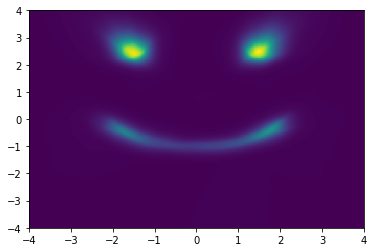

In [ ]:
nce = NCEEnergyModel(0.1, 1.6)
res = nce.fit(traindata[0])

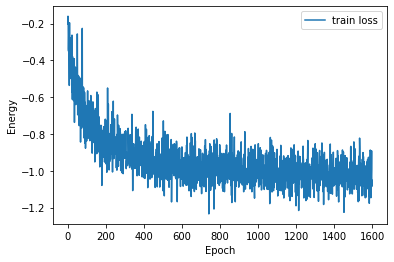

In [ ]:
plot(res)

Text(0, 0.5, 'Energy')

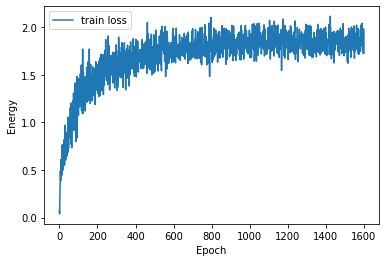

  0%|          | 0/100 [00:00<?, ?it/s]

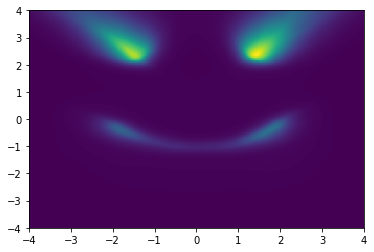

In [ ]:
nce = NCEEnergyModel(0.1, 1.2)
_ = nce.fit(traindata[0])

  0%|          | 0/100 [00:00<?, ?it/s]

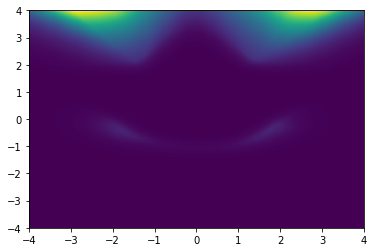

In [ ]:
nce = NCEEnergyModel(0.1, 1)
_ = nce.fit(traindata[0])

  0%|          | 0/100 [00:00<?, ?it/s]

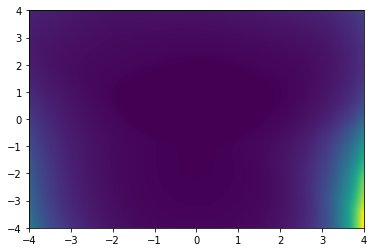

In [ ]:
nce = NCEEnergyModel(0.1, 0.5)
_ = nce.fit(traindata[0])

# Flow

## flow code

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
class AffineTransform(nn.Module):
    def __init__(self, type, n_hidden=2, hidden_size=256):
        super().__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = MLP(input_size=2, n_hidden=n_hidden, hidden_size=hidden_size, output_size=2)

    def build_mask(self, type):
        # if type == "left", left half is a one
        # if type == right", right half is a one
        assert type in {"left", "right"}
        if type == "left":
            mask = torch.FloatTensor([1.0, 0.0])
        elif type == "right":
            mask = torch.FloatTensor([0.0, 1.0])
        else:
            raise NotImplementedError
        return mask

    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1)
        x_ = x * mask

        log_s, t = self.mlp(x_).split(1, dim=1) #todo: fix
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class SigmoidFlow(nn.Module):
    def forward(self, x, reverse=False):        
        if reverse:
            z = - torch.log(torch.reciprocal(x) - 1)
        else:
            z = torch.sigmoid(x)
        return z, z.log() + (1-z).log()

class RealNVP(nn.Module):
    def __init__(self):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.transforms = nn.ModuleList([AffineTransform("left", n_hidden=2, hidden_size=64),
                                         AffineTransform("right", n_hidden=2, hidden_size=64),
                                         AffineTransform("left", n_hidden=2, hidden_size=64),
                                         AffineTransform("right", n_hidden=2, hidden_size=64),
                                         AffineTransform("left", n_hidden=2, hidden_size=64), 
                                         AffineTransform("right", n_hidden=2, hidden_size=64)])
        
    def flow(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        # z -> x (inverse of f)
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z)

    def nll(self, x):
        return - self.log_prob(x).mean()
    
    def fit(self, traindata, lr=1e-3):
        lr = 5e-3
        opt = optim.Adam(self.parameters(), lr=lr)
        train_loader = data.DataLoader(traindata, batch_size=128, shuffle=True)

        for epoch in tqdm(range(250)):
            for i, batch in enumerate(train_loader):
                loss = self.nll(batch.float())
                opt.zero_grad()
                loss.backward()
                opt.step()
        plot_density(self.log_prob)


## result

  0%|          | 0/250 [00:00<?, ?it/s]

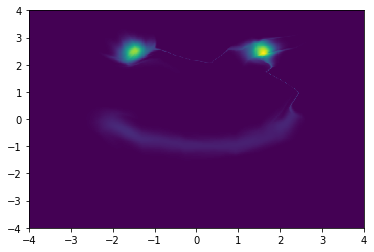

In [ ]:
flow = RealNVP()
flow.fit(traindata[0])

# Flow constrastive estimation

In [ ]:
class EBM(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        
        self.model = Net()
        self.log_z = nn.Parameter(torch.Tensor([0.]), requires_grad=True)

        self.alpha = alpha
 
    def forward(self, x):
        z = self.model(x)
        return z

In [ ]:
class FCEEnergyModel(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.ebm = EBM(alpha)
        self.flow = RealNVP()
    
    def loss(self, batch, noise=0):
        real_x = batch + torch.randn_like(batch) * noise
        real_x = real_x.float().to(device)
        

        real_f = self.ebm(real_x)
        log_prob_real = self.flow.log_prob(real_x).unsqueeze(1)
        den_real = torch.logsumexp(torch.cat((real_f, self.ebm.log_z + log_prob_real)), dim=1)
        loss_real = (real_f - den_real).mean()


        fake_x = self.flow.sample(real_x.shape[0]).squeeze()
        
        fake_f = self.ebm(fake_x)
        log_prob_fake = self.flow.log_prob(fake_x).unsqueeze(1)
        den_fake = torch.logsumexp(torch.cat((fake_f, self.ebm.log_z + log_prob_fake)), dim=1)
        loss_fake = self.ebm.log_z + (log_prob_fake - den_fake).mean()


        loss = loss_real + loss_fake

        regloss = self.ebm.alpha * (real_f ** 2 + fake_f ** 2).mean()
        return loss, regloss
    
    def fit(self, traindata, lr=1e-3, beta1=0):

        opt_ebm = optim.Adam(self.ebm.parameters(), lr=lr, betas=(beta1, 0.999))
        opt_flow = optim.Adam(self.flow.parameters(), lr=lr)

        scheduler_ebm = optim.lr_scheduler.StepLR(opt_ebm, 1, gamma=0.97) 
        scheduler_ebm = optim.lr_scheduler.StepLR(opt_flow, 1, gamma=0.97)

        train_loader = data.DataLoader(traindata, batch_size=128, shuffle=True)

        for epoch in tqdm(range(250)):
            for i, batch in enumerate(train_loader):
                disc, reg = self.loss(batch)
                if i % 2 == 0:
                    loss = -disc + reg
                    opt_ebm.zero_grad()
                    loss.backward()
                    opt_ebm.step()
                else:
                    loss = disc + reg
                    opt_flow.zero_grad()
                    loss.backward()
                    opt_flow.step()
        

        plot_density(self.ebm)

  0%|          | 0/250 [00:00<?, ?it/s]

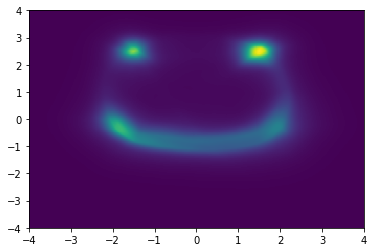

In [ ]:
fce = FCEEnergyModel()
fce.fit(traindata[0])

# Temperature

In [ ]:
class FCEEnergyModelTemp(nn.Module):
    def __init__(self, alpha=0.1, t0=100, t1=1):
        super().__init__()
        self.ebm = EBM(alpha)
        self.flow = RealNVP()
        self.t0 = t0
        self.t1 = t1
        self.t = self.t0
    
    def loss(self, batch, noise=0):
        real_x = batch + torch.randn_like(batch) * noise
        real_x = real_x.float().to(device)
        

        real_f = self.ebm(real_x) / self.t
        log_prob_real = self.flow.log_prob(real_x).unsqueeze(1)
        den_real = torch.logsumexp(torch.cat((real_f, self.ebm.log_z + log_prob_real)), dim=1)
        loss_real = (real_f - den_real).mean()


        fake_x = self.flow.sample(real_x.shape[0]).squeeze()
        
        fake_f = self.ebm(fake_x) / self.t
        log_prob_fake = self.flow.log_prob(fake_x).unsqueeze(1)
        den_fake = torch.logsumexp(torch.cat((fake_f, self.ebm.log_z + log_prob_fake)), dim=1)
        loss_fake = self.ebm.log_z + (log_prob_fake - den_fake).mean()


        loss = loss_real + loss_fake

        regloss = self.ebm.alpha * (real_f ** 2 + fake_f ** 2).mean()
        return loss, regloss
    
    def fit(self, traindata, lr=1e-3, beta1=0):

        opt_ebm = optim.Adam(self.ebm.parameters(), lr=lr, betas=(beta1, 0.999))
        opt_flow = optim.Adam(self.flow.parameters(), lr=lr)

        scheduler_ebm = optim.lr_scheduler.StepLR(opt_ebm, 1, gamma=0.97) 
        scheduler_ebm = optim.lr_scheduler.StepLR(opt_flow, 1, gamma=0.97)

        train_loader = data.DataLoader(traindata, batch_size=128, shuffle=True)

        for epoch in tqdm(range(250)):
            self.t = max(1, self.t0 + (self.t1 - self.t0) * epoch / 100)
            for i, batch in enumerate(train_loader):
                disc, reg = self.loss(batch)
                if i % 2 == 0:
                    loss = -disc + reg
                    opt_ebm.zero_grad()
                    loss.backward()
                    opt_ebm.step()
                else:
                    loss = disc + reg
                    opt_flow.zero_grad()
                    loss.backward()
                    opt_flow.step()
        

        plot_density(self.ebm)

  0%|          | 0/250 [00:00<?, ?it/s]

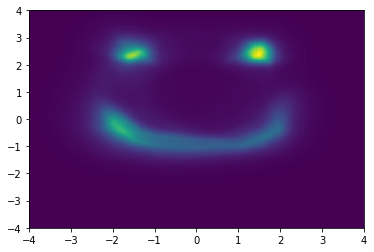

In [ ]:
fce = FCEEnergyModelTemp(t0=10, t1=1)
fce.fit(traindata[0])